# 11장 종양 탐지를 위한 분류 모델 훈련


## 11.1 기본 모델과 훈련 루프

이번 장에서는 분류 모델과 훈련 루프를 만들 예정이다. 이걸 위해 앞 장에서 만든 CT 클래스와 LunaDataset 클래스를 DataLoader 인스턴스에 넣는다. 그리고 다음 단계로 이 인스턴스를 데이터와 함께 훈련 루프와 검증 루프를 거쳐 분류 모델에 입력한다

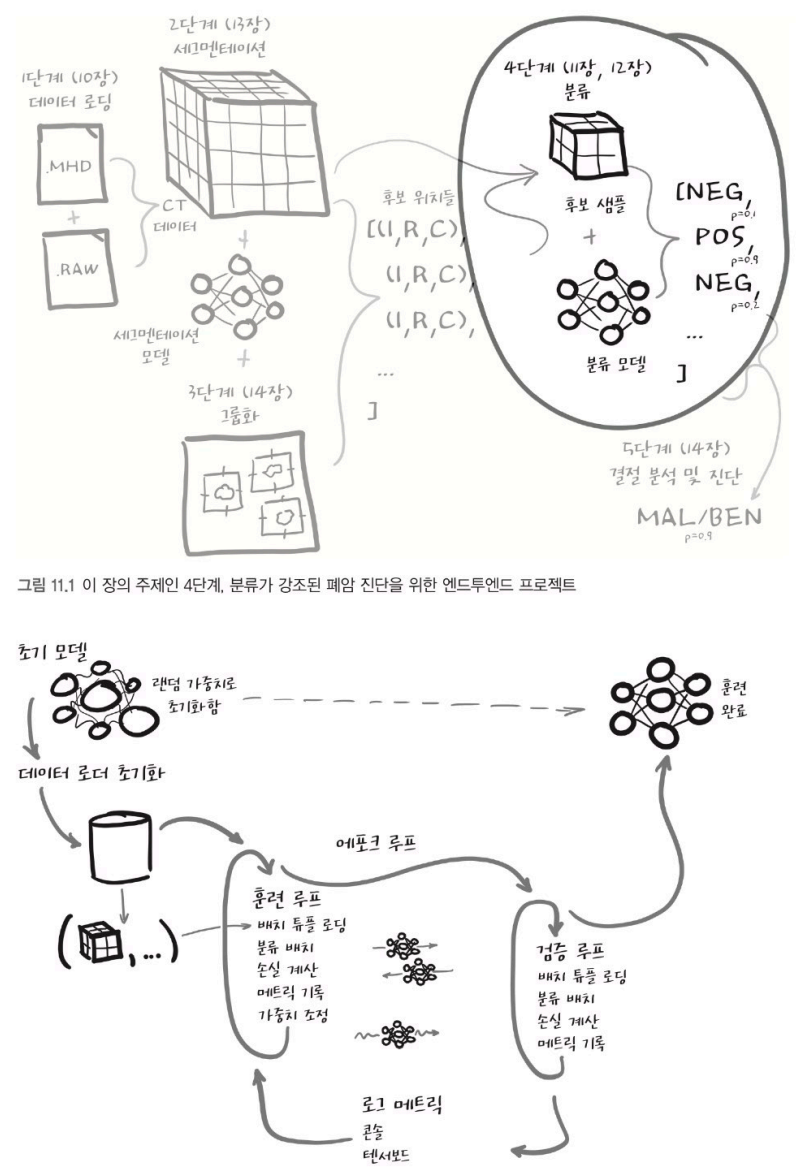

구현의 기본 구조는 다음과 같다
1. 모델을 초기화하고 데이터를 로딩한다
2. 어느 정도 임의로 선택한 에포크 수로 루프를 반복한다.
    - LunaDataset이 반환한 훈련 데이터의 배치 루프를 돈다.
    - 백그라운드에서 데이터로더 워커 프로세스는 적합한 배치를 읽어들인다.
    - 배치를 분류 모델에 전달하여 결과를 얻는다
    - 추정 결과를 실축 데이터와 비교하여 손실을 계산한다
    - 임시 데이터 구조에 모델의 성능 메트릭을 기록한다
    - 오차 역전파로 모델 가중치를 조정한다.
    - (훈련 루프와 유사하게) 검증 데이터 배치로 루프 반복
    - (백그라운드 워커 프로세스에서) 검증 데이터 배치를 읽어들인다
    - 배치를 분류하고 손실을 계싼한다
    - 모델이 검증 데이터에 대해 얼마나 잘 동작했는지를 기록한다
    - 매 에포크마다 진행 상황과 성능 정보를 출력한다.

## 11.2 애플리케이션의 메인 진입접

앞에서 진행한 훈련과 구조적인 큰 차이는 2부가 완전한 명령행 애플리케이션이라는 점이다. 명령행 인자를 파싱하고 완전한 --help 옵션을 제공하며 여러 환경에서 쉽게 실행할 수 있다. 애플리케이션은 클래스로 구현하여 필요할 때 인스턴스로 만들어 실행한다. 함수 호출이나 OS 레벨의 프로세스로 훈련을 구동할 수 있다면 함수 호출을 래핑하여 주피터 노트북에 넣을 수 있으므로, 코드를 쉽게 네이티브 CLI나 브라우저에서 호출할 수 있는 장점이 있다.

In [ ]:
def run(app, *argv):
    argv = list(argv)
    argv.insert(0, '--num-workers=4')  # <1>
    log.info("Running: {}({!r}).main()".format(app, argv))
    
    app_cls = importstr(*app.rsplit('.', 1))  # <2>
    app_cls(argv).main()
    
    log.info("Finished: {}.{!r}).main()".format(app, argv))

training.py 파일 밑을 보면 객체를 인스턴스로 만들고 main 메소드를 호출하는 표준 형태의 if main코드를 볼 수 있다.

In [ ]:
if __name__== '__main__':
    LunaTrainingApp().main()

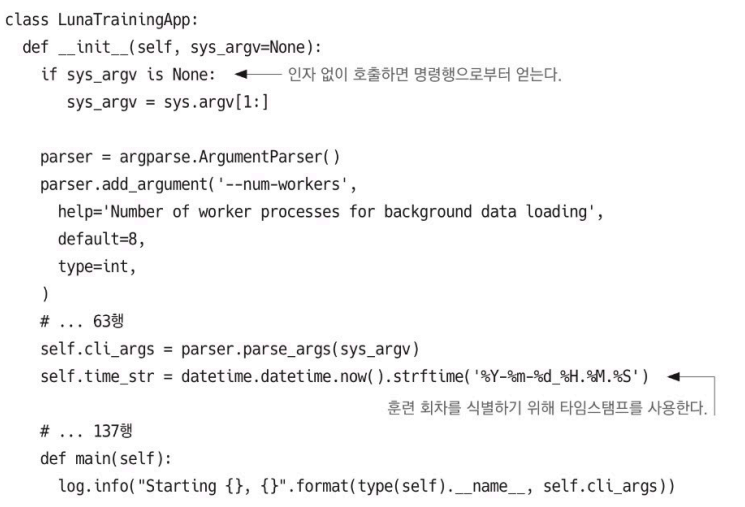

__init__함수에서 표준 argparse 라이브러리를 사용하여 명령행 인자를 받고, main 메소드는 애플리케이션의 핵심 로직을 위한 진입점이다.

## 11.3 사전 훈련 설정과 초기화

에포크를 돌리며 훈련 전 초기화가 필요하다. 첫 번째는 모델과 옵티마이저 초기화이고, 두 번쨰는 Dataset과 DataLoader 인스턴스 초기화다. LunaDataset은 랜덤으로 선택한 샘플셋을 정의하여 훈련 에포크를 채워주고 DataLoader 인스턴스는 데이터셋으로부터 데이터를 읽는 작업을 수행하여 애플리케이션에 제공한다.

### 11.3.1 모델과 옵티마이저 초기화

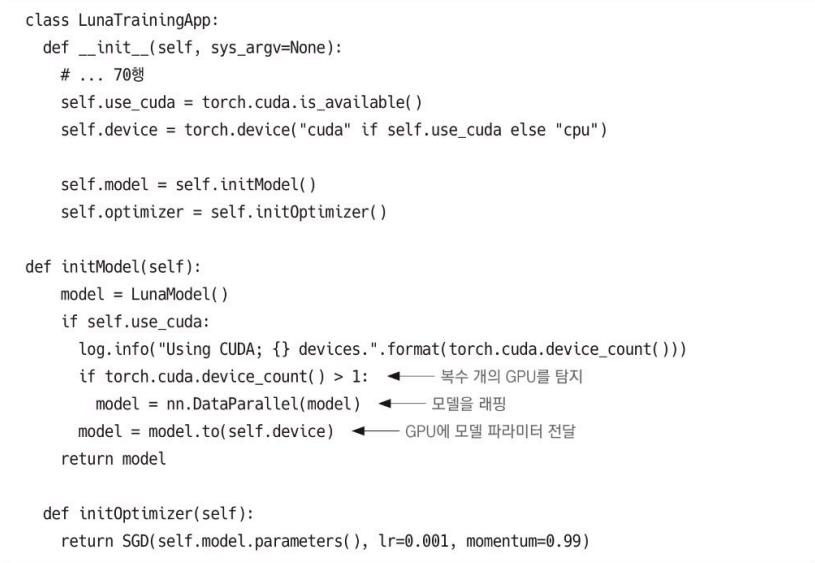

GPU를 사용하는지 여부를 use_cuda에 저장하고, 만약 GPU가 복수개라면 nn.DataParallel 클래스를 사용하여 모든 GPU에 작업을 분산해서 처리 후 파라미터를 다시 모아 조정 작업을 재동기화하는 방식으로 진행한다.옵티마이저 구성 전에 미리 해야 한다. 만약 설정하지 않으면 옵티마이저는 CPU 상의 파라미터 객체를 바라본다. 모멘텀과 함꼐 기본 옵티마이저로 SGD를 사용한다. SGD, 학습률 0.001, 모멘텀 0.9도 안전한 선택이다. 만약 학습이 잘 안되면 학습률을 0.01이나 0.0001로 바꿔 시도해볼 수 있다.\
이 값이 최선이라는 의미는 아니라 학습률, 모멘텀, 신경망 규모 등 기타 유사한 설정을 체계적으로 바꿔가며 찾아가는 과정을 하이퍼파라미터 탐색이라고 한다. 

### 11.3.2 데이터 로더의 관리와 데이터 공급

앞에서 만든 LunaDataset 클래스는 우리가 확보한 거친 원본 데이터와 파이토치 빌딩 블럭을 위한 구조화된 텐서 사이의 가교 역활을 한다. CT 3차원 이미지를 5차원 입력(N, C, D, H, W)로 바꿔줘야 한다. 

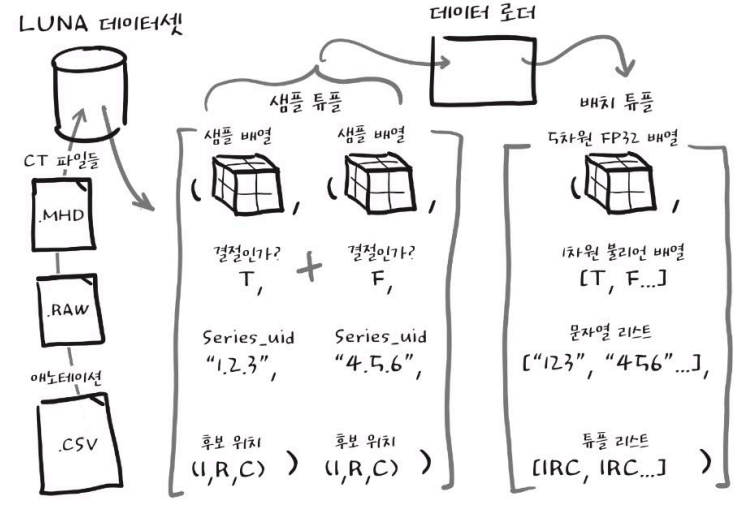

In [ ]:
def initTrainDl(self):
    train_ds = LunaDataset( # 커스텀 LunaDataset
        val_stride = 10,
        isValset_bool=False,
    )
    batch_size = self.cli_args.batch_size
    if self.use_cuda:
        batch_size *= torch.cuda.device_count() #GPU가 하나 이상이면 그만큼 배치 사이즈를 늘려줘야 함
    train_dl = DataLoader( # 바로 사용하면 되는 클래스
        train_ds,
        batch_size=batch_size,
        num_workers=self.cli_args.num_workers,
        pin_memory=self.use_cuda,
    )
    return train_dl

데이터 로더는 개별 샘플을 배치로 만들 뿐만 아니라, 별도의 프로세스와 공유 메모리를 사용한 병렬 로딩도 제공한다. 

## 11.4 첫 번째 경로 신경망 설계

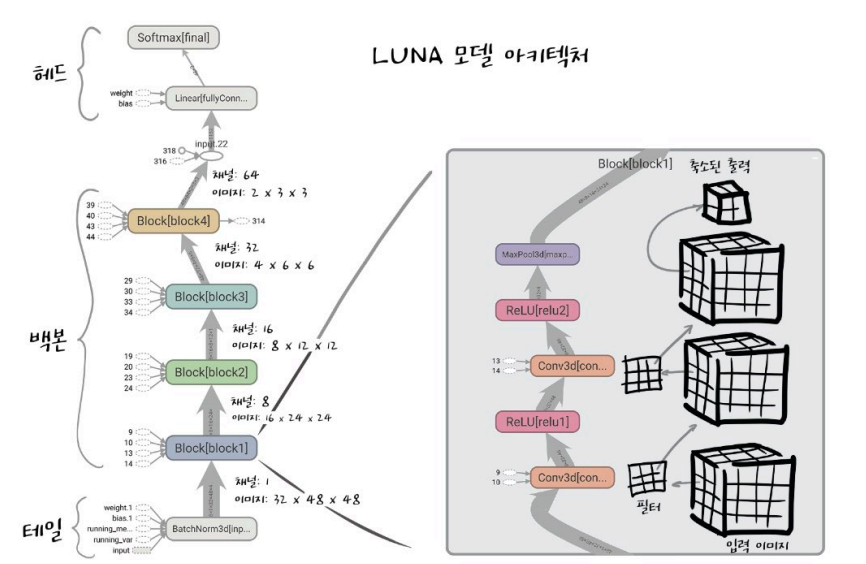

### 11.4.1 핵심 컨볼루션

분류 모델에서는 테일, 백본(or 바디), 헤드로 구성된 구조가 흔하다. 테일은 입력을 신경망에 넣기 전 처리 과정을 담당하는 제일 첫 부분의 일부 계층이다. 이러한 앞 단 계층은 백본이 원하는 형태로 입력을 만들어야 하므로 신경망의 나머지 부분과는 구조나 구성이 다른 경우가 많다. 여기서는 단순히 배치 정규화 계층만 사용하지만 테일에 컨볼루션층이 들어 있는 경우도 있다. 테일에 들어 있는 컨볼루션은 이미지 크기를 공격적으로 다운샘플링하기 위한 용도가 대부분이다. 우리 이미지는 32x48x48 비교적 작으므로 다운샘플링이 필요하지 않다\
백본은 여러 계층을 가지는데 일반적으로는 연속된 블럭에 배치된다. 각 블럭은 동일한 세트의 계층을 가지며 블럭을 거칠 때마다 필요한 입력 크기나 필터가 바뀐다. 우리는 3x3 커널, 하나의 활성화, 블록 끝에 맥스 풀링 연산이 이어진 블록을 사용한다. 블럭을 코드로 구현하면 다음과 같다

In [ ]:
class LunaBlock(nn.Module): # nn.Module 상속
    def __init__(self, in_channels, conv_channels):
        super().__init__()
        self.conv1 = nn.Conv3d( # 첫 번쨰 컨볼루션 층, 입력 채널, 컨볼루션 채널, 커널 사이즌 3, 패딩은 1, 편향 사용
            in_channels, conv_channels, kernel_size=3, padding=1, bias=True,
        )
        self.relu1 = nn.ReLU(inplace=True) #활성화 함수로 ReLU 함수 사용함
        self.conv2 = nn.Conv3d( #두 번째 컨볼루션 계층
            conv_channels, conv_channels, kernel_size=3, padding=1, bias=True,
        )
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool3d(2, 2)
        
    def forward(self, input_batch):
        block_out = self.conv1(input_batch)
        block_out = self.relu1(block_out)
        block_out = self.conv2(block_out)
        block_out = self.relu2(block_out)
        
        return self.maxpool(block_out)

신경망의 헤드는 백본의 출력을 받아 원하는 출력 형태로 바꾼다. 이 작업은 중간 출력물을 평탄화하고 완전 연결 계층에 전달하는 역활을 하기도 한다. 이미지 객체가 많은 구조를 가지거나 구별할 클래스가 많은 경우 두 번째 완전 연결 계층이 적합하지만 우리는 하나의 평탄화 계층만 사용한다.\
이와 같은 구조는 컨볼루션 신경망을 처음 만드는 빌딩 블록에 적합하다. 더 복잡한 설계도 많지만 이유가 명확할 때 하나씩 복잡성을 추가하는 것이 좋다

이 블럭에서는 3x3x3 컨볼루션을 사용한다, 3x3x3 컨볼루션은 거의 동일하게 3x3x3 크기의 수용 필드를 가지게 된다. 한 블럭에서 두 번의 3x3x3 컨볼루션이 이루어짐으로, 최종 출력은 5x5x5의 수용 필드를 가지게 된다. 결과적으로 두 개의 3x3x3 컨볼루션은 5x5x5 컨볼루션보다 더 적은 파라미터를 가진다. 패딩이 1이므로 이미지 경계에 가상의 한 픽셀에 해당하는 추가 ㅇㅇ역이 들어간다. 이렇게 해서 입력과 출력 이미지 크기는 동일하다. 

### 11.4.2 전체 모델
이제 모델 전체 구현을 해보자

In [ ]:
class LunaModel(nn.Module):
    def __init__(self, in_channels=1, conv_channels=8):
        super().__init__()
        self.tail_batchnorm = nn.BatchNorm3d(1) # 테일
        
        self.block1 = LunaBlock(in_channels, conv_channels) # 첫 번째 백본 블럭
        self.block2 = LunaBlock(conv_channels, conv_channels*2)
        self.block3 = LunaBlock(conv_channels*2, conv_channels*4)
        self.block4 = LunaBlock(conv_channels*4, conv_channels*8)
        
        self.head_linear = nn.Linear(1152, 2)
        self.head_softmax = nn.Softmax(dim=1) # 헤드

nn.BatchNorm3d를 사용해 입력값을 이동시키고 비율을 조정해서 평균이 0이고 표준 정규분포 1을 따르도록 만든다. 백본에서는 네 개의 반복 블럭이 있고 블럭 구현은 nn.Module의 서브클래스를 사용했다. 처음 32x48x48이었던 데이터 덩어리가 2x3x3이 된다. 마지막 테일에서는 완전 연결 계층 뒤로 nn.Softmax가 따라온다. 

여기서 self.block4를 완전 연결 계층에 넣을 때 문제가 발생하는데, 평탄화 작업을 하지 않았기 때문이다. LunaModel 클라스의 forward 메소드를 살펴보자

In [ ]:
def forward(self, input_batch):
    bn_output = self.tail_batchnorm(input_batch)
    
    block_out = self.block1(bn_output)
    block_out = self.block2(bn_output)
    block_out = self.block3(bn_output)
    block_out = self.block4(bn_output)
    
    conv_flat = block_out.view(block_out.size(0), -1) # 1차원 벡터의 배치를 받으므로 배치 사이즈가 axis0으로 view해줌
    linear_output = self.head_linear(conv_flat)
    
    return linear_output, self.head_softmax(linear_output)

마지막으로 신경망 파라미터 초기화를 살펴보자. 모델이 좋은 성능을 내려면 모델의 가중치, 편향값, 여러 파라미터가 특정 속성을 드러내야 한다. 신경망의 모든 가중치가 1보다 커지는 안좋은 상황에서는 계층 출력 값이 매우 커지게 된다. 비슷하게 1보다 작은 가중치는 아예 없어지게 만든다(vanishing gradient). 가장 단순한 방법은 중간값이나 기울기가 작아지거나 커지지 않도록 신경망 가중치가 확실히 초기화되게 하는 것이다.

In [ ]:
def _init_weights(self):
    for m in self.modules():
        if type(m) in {
            nn.Linear, 
            nn.Conv3d,
        }:
            nn.init.kaiming_normal_(
                m.weight.data, a=0, mode='fan_out', nonlinearity='relu'
            )
            if m.bias is not None:
                fan_in, fan_out = nn.init._calculate_fan_in_and_fan_out(m.weight.data)
                bound=1/math.sqrt(fan_out)
                nn.init.normal_(m.bias, -bound, bound)

## 11.5 모델 훈련과 검증
이제 우리가 지금까지 다룬 각 부분을 조립해서 실제로 동작시켜 보자

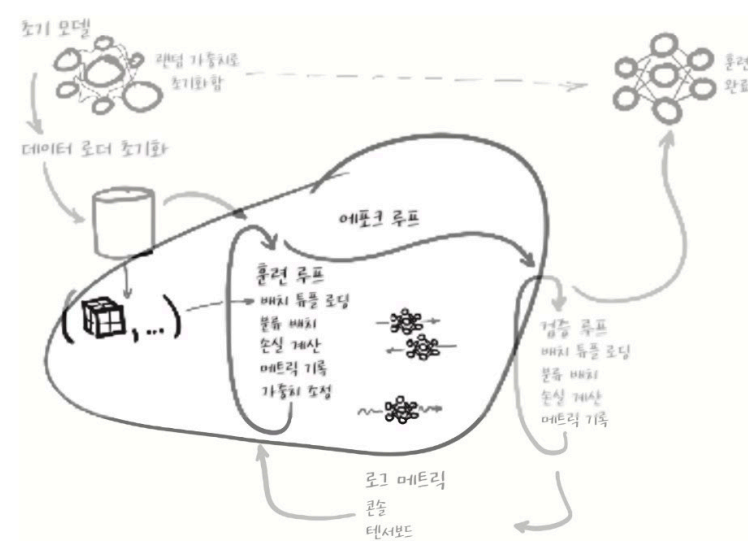

In [ ]:
def main(self):
    for epoch_ndx in range(1, self.cli_args.epochs+1):
        trnMetrics_t = self.doTraining(epoch_ndx, train_dl)
        self.logMetrics(epoch_ndx, 'trn', 'trnMetrics_t')
        
def doTraining(self, epoch_ndx, train_dl):
    self.model.train()
    trnMetrics_g = torch.zeros( # 빈 메트릭 배열 초기화
        METRICS_SIZE,
        len(train_dl.dataset()),
        device=self.device,
    )
    
    batch_iter = enumerateWithEtimate( # 완료 시간을 예측하여 배치 루프 설정
    train_dl,
    "E{} Training".format(epoch_ndx)
    start_ndx = train_dl.num_workers,
    )
    for batch_ndx, batch_tup in batch_iter:
        self.optimizer.zero_grad() #남은 가중치 텐서 해제
        
        loss_var = self.computeBatchLoss(#손실 계산을 배치 단위로 함
            batch_ndx,
            batch_tup,
            train_dl.batch_size,
            trnMetrics_g
        )
        loss_var.backward()
        self.optimizer.step() #모델 가중치 조정
    
    self.totalTrainingSamples_count += len(train_dl.dataset)
    
    return trnMetrics_g.to('cpu')

### 11.5.1 computeBatchLoss 함수
이 함수는 샘플 배치에 대해 손실을 계산한다. 부가적으로 각 샘플에 대해 모델이 만들어내는 출력에 대한 정보도 계산해서 기록한다. 이것으로 각 클래스별로 계산이 얼마나 정확한지 백분율로 계산할 수 있으며, 분류가 되지 않는 클래스를 찾아 집중 개선할 수 있다.\
이 함수의 핵심 기능은 배치 단위로 모델에 입력을 넣고 손실을 계산하는 것이며, CrossEntropyLoss를 사용한다. 

In [ ]:
def computeBatchLoss(self, batch_ndx, batch_tup, batch_size, metrics_g):
    input_t, label_t, _series_list, _center_list = batch_tup
    
    input_g = input_t.to(self.device, non_blocking=True)
    label_g = label_t.to(self.device, non_blocking=True)
    
    logits_g, probability_g = self.model(input_g)
    loss_func = nn.CrossEntropyLoss(reduction='none')
    loss_g = loss_func(
        logits_g,
        label_g[:,1], #원핫 인코딩 클래스의 인덱스
    )
    return loss_g.mean() #샘플별 손실값을 단일값으로 합친다

배치 단위로 평균을 내지 않고 손실값이 있는 텐서를 샘플마다 얻는다. 이렇게 하면 각 클래스마다 손실값을 추적할 수 있고 원하는 방식으로 병합할 수 있다. 샘플별로 통계값을 가질 이유가 없다면 사용하지 않아도 문제가 없다.

In [ ]:
start_ndx = batch_ndx * batch_size
        end_ndx = start_ndx + label_t.size(0)

        metrics_g[METRICS_LABEL_NDX, start_ndx:end_ndx] = \ #레이블 매트릭스
            label_g[:,1].detach() #detach 함수로 복사해준다
        metrics_g[METRICS_PRED_NDX, start_ndx:end_ndx] = \ # 확률값 매트릭스
            probability_g[:,1].detach()
        metrics_g[METRICS_LOSS_NDX, start_ndx:end_ndx] = \ # 손실 매트릭스
            loss_g.detach()

        return loss_g.mean() #전체 배치에 대한 손실값

### 11.5.2 훈련 때와 유사한 검증 루프

In [ ]:
def main(self):
    for epoch_ndx in range(1, self.cli_args.epochs+1):
        #----
        valMetrics_t = self.doValidation(epoch_ndx, val_dl)
        
    self.logMetrics(epoch_ndx, 'val', valMetrics_t)
    
#--------
def doValidation(self, epoch_ndx, val_dl):
    with torch.no_grad():
        self.model.eval()
        valMetrics_g = torch.zeros(
            METRICS_SIZE,
            len(val_dl.dataset),
            device=self.device,
        )
        
        batch_iter = enumerateWithEstimate(
            val_dl,
            "E{} Validation".format(epoch_ndx),
            start_ndx =val_dl.num_workers,
        )
        for batch_ndx, batch_tup in batch_iter:
            self.computeBatchLoss(batch_ndx, batch_tup, val_dl.batch_size, valMetrics_g)
            
    return valMetrics_g.to('cpu')

## 11.6 성능 메트릭 출력

에포크의 마지막 작업은 성능 메트릭을 로깅하는 것이다. 훈련 과정을 진행할수록 결과와 진행 단계를 로깅하는 것은 중요하다. 초기에 우리는 각 에포크마다 진행 상태를 로깅하기 위해 결과를 trnMetrics_g와 valMetrics_g에 수집하고 있었다. 

### 11.6.1 logMetrics 함수

logMetrics 함수 시그니처는 다음과 같다

In [ ]:
def logMetrics(
    self,
    epoch_ndx,
    mode_str,
    metrics_t,
    classificationThreshold=0.5,
):

epoch_ndx는 결과를 로깅할 떄 표시하기 위한 용도로 사용한다. mode_str 인자는 메트릭이 훈련용인지 검증용인지를 나타낸다. 훈련인지 검증인지 여부에 따라 trnMetrics_t나 valMetrics_t를 사용할지 결정되는데 둘 다 metrics_t 파라미터로 전달된다. 두 입력 모두 computeBatchLoss에서 만들어진 부동소수점 데이터 텐서이며, doTraining과 doValidation으로부터 반환하기 직전에 CPU 영역으로 전송된다. 둘다 세 개의 행과 샘플 수만큼의 열을 가진다. 세 개의 행은 다음의 상수와 동일하다

In [ ]:
METRICS_LABEL_NDX=0
METRICS_PRED_NDX=1
METRICS_LOSS_NDX=2
METRICS_SIZE=3

마스킹 구성:\
마스킹: 원본 데이터와 다른 가짜이지만 같은 포맷을 가진 현실 같은 가짜 데이터\
출처: https://www.imperva.com/learn/data-security/data-masking/

결절 샘플 또는 비결절 샘플에 대해서만 메트릭을 제한하는 마스크를 만들어보자. 그리고 클래스별 총 샘플 수와 잘 분류된 샘플의 수를 모두 세어보자

In [ ]:
negLabel_mask = metrics_t[METRICS_LABEL_NDX] <= classificationThreshold
negPred_mask = metrics_t[METRICS_PRED_NDX] <= classificationThreshold
posLabel_mask = ~negLabel_mask
prosPred_mask = ~negPred_mask

결절의 상태 레이블은 True:1, False:0이므로, metrics_t[METRICS_LABEL_NDX]에 저장된 값은 0.0, 1.0 범위에 속한다. classificationThreshold의 기본값은 0.5로 설정되어 비교하여 이진값 배열을 얻게 되면, True는 음성의 레이블에 해당한다\
양수 마스킹은 음수 마스킹의 반대면 된다. 

이제 레이블별 통계를 계싼하기 위해 마스크를 사용하고 metrics_dict 딕셔너리에 결과를 저장하자

In [ ]:
neg_count = int(negLabel_mask.sum()) #파이썬 정수로 변환/ 음성 개수
pos_count = int(posLabel_mask.sum())# 양성 개수

neg_correct = int((negLabel_mask & negPred_mask).sum()) #음성 중 예측 맞춘 것 개수
pos_correct = int((posLabel_mask & posPred_mask).sum()) #양성 중 에측 맞춘 것 개수

metrics_dict = {}
metrics_dict['loss/all'] = metrics_t[METRICS_LOSS_NDX].mean() # 에포크 전체에 대한 평균 손실값
metrics_dict['loss/neg'] = metrics_t[METRICS_LOSS_NDX, negLabel_mask].mean() # negLabel_mask로 음성으로 레이블된 샘플에 대한 손실값
metrics_dict['loss/pos'] = metrics_t[METRICS_LOSS_NDX, posLabel_mask].mean() # 양성 샘플 손실값
metrics_dict['correct/all'] = (pos_correct + neg_correct) / np.float32(metrics_t.shape[1]) * 100 # np.float으로 정수 나눗셈 피함/ 전체 맞은 백분율
metrics_dict['correct/neg'] = neg_correct / np.float32(neg_count) * 100 # 음성 맞춘 백분율
metrics_dict['correct/pos'] = pos_correct / np.float32(pos_count) * 100 # 양성 맞춘 백분율

계산이 끝나면 세 번의 log.info 호출을 통해 결과 로깅

In [ ]:
log.info(
            ("E{} {:8} {loss/all:.4f} loss, "
                 + "{correct/all:-5.1f}% correct, " # 모든 샘플에 대한 손실
            ).format(
                epoch_ndx,
                mode_str,
                **metrics_dict,
            )
        )
        log.info(
            ("E{} {:8} {loss/neg:.4f} loss, " # 음성 샘플에 대한 손실
                 + "{correct/neg:-5.1f}% correct ({neg_correct:} of {neg_count:})"
            ).format(
                epoch_ndx,
                mode_str + '_neg',
                neg_correct=neg_correct,
                neg_count=neg_count,
                **metrics_dict,
            )
        )
        log.info(
            ("E{} {:8} {loss/pos:.4f} loss, " # 양성 샘플에 대한 손실
                 + "{correct/pos:-5.1f}% correct ({pos_correct:} of {pos_count:})"
            ).format(
                epoch_ndx,
                mode_str + '_pos',
                pos_correct=pos_correct,
                pos_count=pos_count,
                **metrics_dict,
            )
        )

## 11.7 훈련 스크립트 실행

주피터 노트북을 제공해주므로 run 함수를 통해 실행할 수 있다

In [ ]:
run('p2ch11.prepcache.LunaPrepCacheApp')
run('p2ch11.training.LunaTrainingApp', '--epochs=1')

첫 에포크 실행이 굉장히 오래 걸린다면 LunaDataset이 필요한 데이터를 캐싱하느라 그랬을 수 있다. 여기서는 prepcache 함수를 지원하여 수행 시간을 줄여줄 수 있다.

### 11.7.1 훈련에 필요한 데이터

샘플 수를 확인하고 우리가 가지고 있는 subset# 파일에 샘플 수와 맞는지 확ㅇ니해야 한다. 

### 11.7.2 enumerateWithEstimate 함수 알아보기

머신을 돌려놓고 굉장히 오래 기다려야 한다. 이 때 예상 시간을 알려주는 함수인 enumerateWithEstimate 함수를 사용해볼 수 있다. 

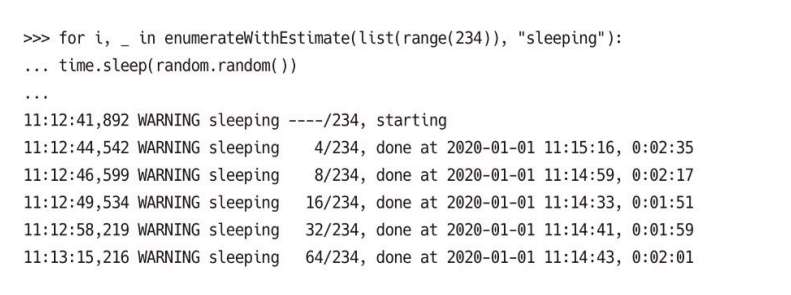

언제 작업이 끝나는지 안다면 시간을 효율적으로 사용할 수 있고, 제대로 동작하지 않을때 문제를 파악할 수 있다.

## 11.8 모델 평가

훈련 스크립트의 출력 내용을 살펴보자

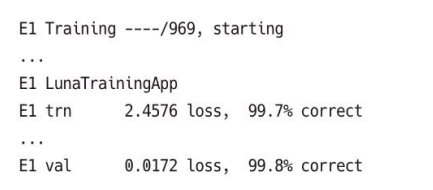

한 번의 에포크 후에 정확도가 99.7%이다. 요약된 부분을 좀 풀어서 에포크 1 출력을 살펴보자

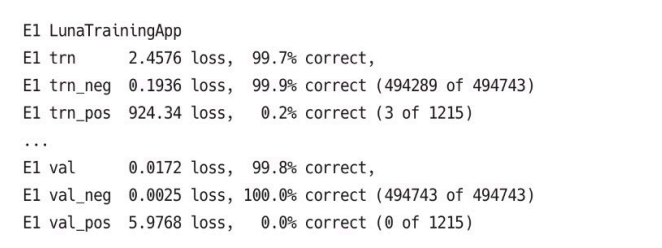

검증셋에 대해 비결절인 것은 100% 정확하게 구별했지만 결절인 것은 100% 틀렸다. 이 신경망은 단순히 모든 것이 결절이 아니다라고 판단을 내렸다. 10 에포크를 지나도 미미하게 나아질 뿐이다.

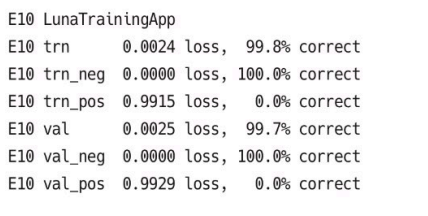

val_pos 손실값이 줄어들었지만 val_neg 손실값의 증가는 발생하지 않았다. 신경망의 학습은 발생하고 있지만 아주 느리다. 또한, 우리는 악성 종양인지를 파악하는 모델을 만들려고 하는 것이다. 종양을 정상 조직으로 분류하는 상황만큼은 피해야 한다. 이 때 우리가 평가 지표에 대하여 고민해야 할 것이다. 일단 결과를 쉽게 이해할 수 있도록 도구를 업그레이드 해보자.

## 11.9 텐서보드로 훈련 관련 메트릭을 그려보기

### 11.9.1 텐서보드 실행

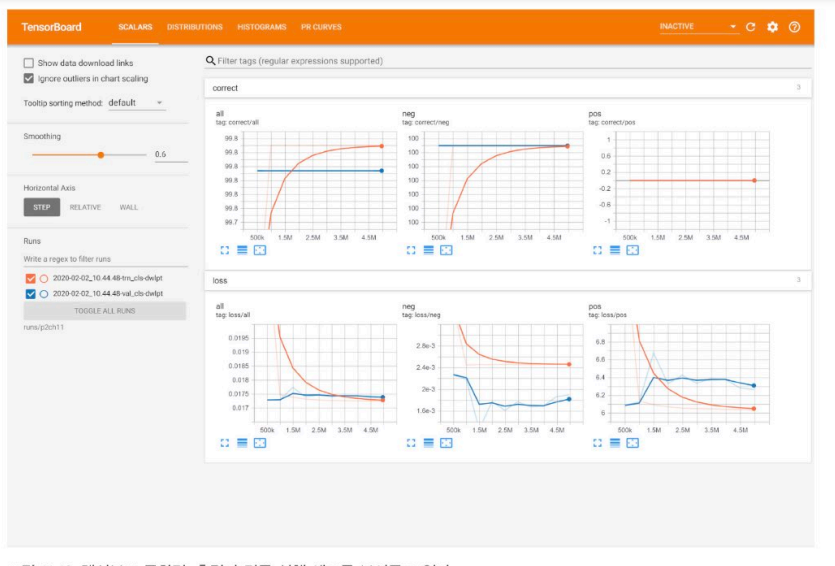

위를 보면 Scalars, Distribution, Histograms, PR Curves 탭이 있는 것을 볼 수 있다. Scalars 텝을 실행해보자.

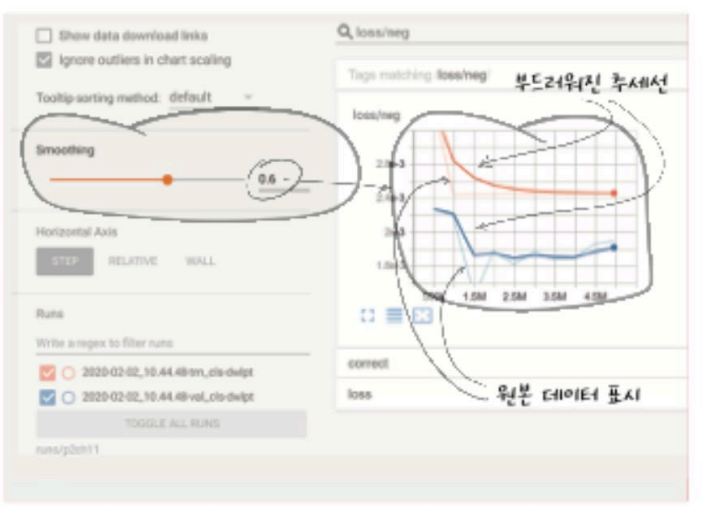

동그라미 쳐진 Smoothing은 데이터에 노이즈가 많이 껴있을 때 전체 추세를 부드럽게 조정할 수 있다. 이제 우리 모델의 그래프를 텐서보드에서 봐보자.

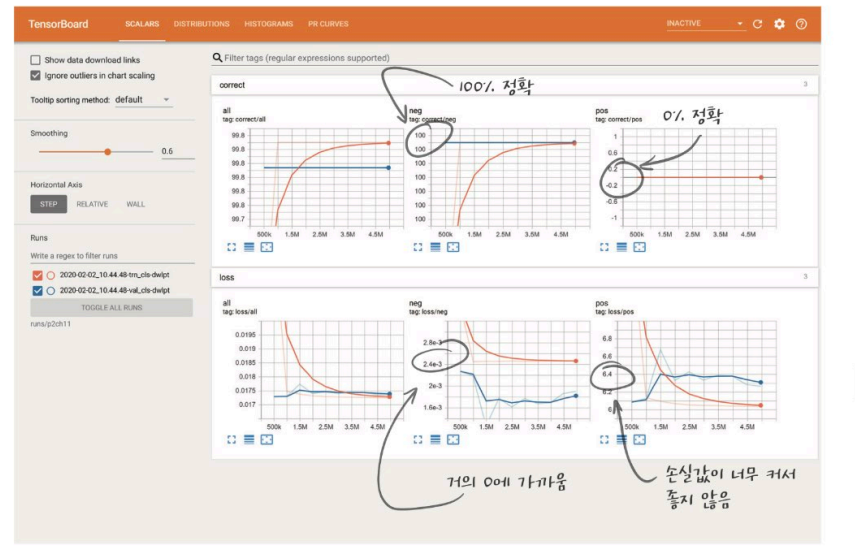

### 11.9.2 메트릭 로깅 함수가 텐서보드를 지원하도록 만들기

torch.utils.tensorboard 모듈을 사용하여 쉽고 빠르게 메트릭 저장이 가능하다. 텐서보드는 넘파이 뱅려과 파이토치 텐서를 지원한다. 제일 먼저 할 것은 SummaryWriter 객체를 만드는 것이다.

In [ ]:
def initTensorboardWriters(self):
        if self.trn_writer is None:
            log_dir = os.path.join('runs', self.cli_args.tb_prefix, self.time_str) # runs/p2ch11/2020-01-01_12.55.27-trn-dlwpt 같은
                                                                                    # log_dir SummaryWriter에 인자로 전달
            self.trn_writer = SummaryWriter(# 훈련용 Writer 객체
                log_dir=log_dir + '-trn_cls-' + self.cli_args.comment)
            self.val_writer = SummaryWriter( # 검증용 Writer 객체
                log_dir=log_dir + '-val_cls-' + self.cli_args.comment)

최초 훈련 에포크는 랜덤한 결과이기 때문에 값을 왜곡시키게 되어있다. 이 때문에 첫 번쨰 에포크에서 나온 메트릭은 무시하는 것도 방법이다. 텐서보드에서는 스무딩을 통해 조금이라도 이런 노이즈를 줄이는 기능을 제공한다.

#### 텐서보드에 스칼라값 쓰기

이미 만들어놓은 metrics_dict의 키/값을 writer.add_scalar 메소드에 전달한다. add_scalar 메소드 시그니처는 다음과 같다

In [ ]:
def add_scalar(self, tag, scalar_value, globa-step=None, walltime=None):
    #...

tag 파ㅏㄹ미터는 텐서보드의 어떤 그래프에 값이 들어가는지를 알려주며 scalar_value 파라미터는 데이터 포인트의 Y축 값이다. global_step은 x축을 당담할 것이다. doTraining 함수 안에서 우리는 writer.add_scalar(key, value, self, totalTrainingSamples_count)로 넘겨줄 것이다. 

## 11.10 모델이 결절 탐지를 학습하지 못하는 이유

책에서는 우리 모델을 한 학생에 비유하며 예시를 들었다. 참/거짓 시험을 보는데 교수님이 30년 동안 한 두 문제만 참이고 나머지는 다 거짓이었다고 하자. 한 학생은 이를 파악하고 전부 거짓으로 적었다. 이런 경우 99%의 정답을 얻었지만, 이 학생이 이 과목을 잟한다고 얘기하기는 어렵다. 이와 반대로 참을 두 개 적은 학생은 앞 학생보다 해당 과목을 훨씬 잘 이해하고 있음을 알 수 있다. 매우 미미하나 손실값이 줄어들고 있으므로, 다음 장에서 이 모델의 가능성을 파악해보자